# Load knowledge base

In [20]:
# !pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

In [34]:
# !pip install nltk

In [33]:
# import nltk
# nltk.download('punkt')
# nltk.download('punkt_tab')

In [2]:
import os
import requests
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS

In [3]:
%reload_ext dotenv
%dotenv

In [4]:
# Configuration
API_BASE_URL = "https://www.courtlistener.com/api/rest/v4/"
API_KEY = os.getenv("COURTLISTENER_API_KEY")  
HEADERS = {"Authorization": f"Token {API_KEY}"}
VECTOR_DIMENSION = 768  
FAISS_INDEX_PATH = "faiss_legal_rag_index.index"

### No. of records

In [5]:
total_records = 10583546

## Delete FAISS Files

In [90]:
# import os
# import shutil
# from langchain.schema import Document
# from langchain.vectorstores import FAISS
# from langchain_community.embeddings import HuggingFaceEmbeddings
# from langchain_community.vectorstores.utils import DistanceStrategy

# def clear_faiss():
#     """Delete FAISS index files to reset FAISS."""
#     if os.path.exists(NEW_FAISS_INDEX_PATH):
#         shutil.rmtree(NEW_FAISS_INDEX_PATH)  # Delete the FAISS directory
#         print("FAISS index deleted!")

# clear_faiss()

FAISS index deleted!


In [91]:
# import os

# if not os.path.exists(NEW_FAISS_INDEX_PATH):
#     print("FAISS index is cleared (directory deleted).")
# else:
#     print("FAISS index still exists.")


FAISS index is cleared (directory deleted).


In [6]:
import requests

# Base URL for the CourtListener opinions API
url = "https://www.courtlistener.com/api/rest/v4/opinions/"
response = requests.get(url)
data = response.json()

# Extract the total count and calculate the number of pages
results_per_page = len(data.get("results", []))

print(f"Opinions per page: {results_per_page}")

Opinions per page: 20


In [7]:
import requests

# Base URL for the CourtListener opinions API
url = "https://www.courtlistener.com/api/rest/v4/opinions/?count=on"
response = requests.get(url)
data = response.json()

total_count = data.get("count", 0)

total_pages = (total_count // results_per_page) + (1 if total_count % results_per_page else 0)

print(f"Total opinions: {total_count}")
print(f"Opinions per page: {results_per_page}")
print(f"Total pages: {total_pages}")


Total opinions: 10560824
Opinions per page: 20
Total pages: 528042


Total opinions: 10560824  
Opinions per page: 20  
Total pages: 528042

## Embedding Model

### Model Information


In [53]:
from sentence_transformers import SentenceTransformer

# Load the embedding model
embedding_model = SentenceTransformer("all-mpnet-base-v2")

print(f"Model loaded: {embedding_model}")

# Check the tokenizer's max sequence length
tokenizer = embedding_model.tokenizer
print("Tokenizer max sequence length:", tokenizer.model_max_length)  # Output: 512

# Check the embedding model's max sequence length
print("Embedding model max sequence length:", embedding_model.max_seq_length)  # Output: 384

/home/renyang/ruxing/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model loaded: SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)
Tokenizer max sequence length: 512
Embedding model max sequence length: 384


## Functions

### 1.1 Split the documents into chunks

In [7]:
# Fetch Data from CourtListener
def fetch_data(endpoint, params=None, limit=100):
    """Fetch data from the CourtListener API."""
    results = []
    while endpoint:
        # print(f"Fetching: {endpoint}")
        response = requests.get(endpoint, headers=HEADERS, params=params)
        if response.status_code != 200:
            print(f"Error: {response.status_code} - {response.text}")
            break

        data = response.json()
        results.extend(data["results"])

        # Handle pagination
        endpoint = data.get("next")
        if len(results) >= limit:
            break

    return results

In [8]:
import re

def clean_text(text):
    """
    Clean the main content in the following ways:
    - Remove excessive whitespace and line breaks
    - Preserve legal citations
    - Handle case headers
    - Manage footnotes 
    - Normalise punctuation
    """
    
    # Normalise line breaks and whitespace
    text = re.sub(r'\r\n|\r|\n', ' ', text)  # Replace different line breaks with space
    text = re.sub(r'\s+', ' ', text).strip()  # Collapse multiple spaces into one

    # Preserve legal citations (e.g., "123 U.S. 456"), this matches common legal citation formats
    citation_pattern = r'(\b\d{1,3}\s+[A-Z][a-zA-Z]*\s+\d+\b)'
    citations = re.findall(citation_pattern, text)
    for citation in citations:
        text = text.replace(citation, f'[{citation}]')

    # Handle case headers and metadata, assuming headers are in uppercase and followed by a colon
    header_pattern = r'([A-Z\s]+:)\s'
    text = re.sub(header_pattern, r'\n\1 ', text)

    # Manage footnotes and annotations
    # Removing footnotes assuming they are enclosed in brackets or parentheses
    text = re.sub(r'\[\d+\]', '', text)  # Remove numeric footnotes like [1]
    text = re.sub(r'\(\d+\)', '', text)  # Remove numeric footnotes like (1)

    # Normalize punctuation spacing
    text = re.sub(r'\s+([.,;:!?])', r'\1', text)  # Remove space before punctuation
    text = re.sub(r'([.,;:!?])([A-Za-z])', r'\1 \2', text)  # Ensure space after punctuation

    return text

In [9]:
from transformers import AutoTokenizer
from nltk.tokenize import sent_tokenize

# Load the tokenizer for your embedding model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")

def chunk_text_semantic(text, max_tokens=384, overlap_tokens=100):
    """
    Split text into semantic chunks while respecting token limits.
    The function prioritizes sentence-level chunking and ensures minimal token loss.
    """

    # Clean the text
    text = clean_text(text)

    # Split text into sentences
    sentences = sent_tokenize(text)

    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        # Tokenize the sentence
        sentence_tokens = tokenizer.tokenize(sentence)
        sentence_length = len(sentence_tokens)

        # If adding this sentence exceeds the max token limit, finalize the current chunk
        if current_length + sentence_length > max_tokens:
            if current_chunk:
                # Convert current chunk to string and store
                chunk_text = tokenizer.convert_tokens_to_string(current_chunk)
                chunks.append(chunk_text)

                # Keep an overlapping portion for continuity
                overlap_start = max(0, len(current_chunk) - overlap_tokens)
                current_chunk = current_chunk[overlap_start:]
                current_length = len(current_chunk)
            
            # If the sentence itself is longer than max_tokens, split it directly
            if sentence_length > max_tokens:
                for i in range(0, sentence_length, max_tokens - overlap_tokens):
                    chunk_text = tokenizer.convert_tokens_to_string(sentence_tokens[i:i + max_tokens - overlap_tokens])
                    chunks.append(chunk_text)
                continue  # Skip adding this sentence again
            
        # Add sentence tokens to the current chunk
        current_chunk.extend(sentence_tokens)
        current_length += sentence_length

    # Add the last chunk if it exists
    if current_chunk:
        chunk_text = tokenizer.convert_tokens_to_string(current_chunk)
        chunks.append(chunk_text)

    return chunks


In [10]:
# Process Raw Knowledge Base
def process_knowledge_base(raw_knowledge_base):
    """Process raw documents into chunks with metadata."""
    docs_processed = []
    for doc in tqdm(raw_knowledge_base, desc="Processing documents"):

        # This is the main content
        text = doc.get("plain_text", "")  
        # All other fields are extracted as metadata
        metadata = {k: v for k, v in doc.items() if k != "plain_text"}  
        
        # Check that text is not empty
        if not text:
            continue
        
        # Chunk the main content and assign the respective metadata
        chunks = chunk_text_semantic(text, max_tokens=384, overlap_tokens=100)
        for i, chunk in enumerate(chunks):
            docs_processed.append({
                "text": chunk,
                "metadata": {**metadata, "chunk_id": i}
            })
    return docs_processed

### 1.2 Building the vector database

In [11]:
from langchain_huggingface import HuggingFaceEmbeddings

In [12]:
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import torch

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

def initialise_faiss(docs_processed, embedding_model):
    """
    Initialise the FAISS index with processed documents and an embedding model.

    Args:
        docs_processed (list): List of dictionaries with 'text' and 'metadata'.
        embedding_model (HuggingFaceEmbeddings): The embedding model to use.

    Returns:
        FAISS: A FAISS vector store with the documents indexed.
    """
    # Ensure embedding_model is passed correctly
    if not isinstance(embedding_model, HuggingFaceEmbeddings):
        raise ValueError("embedding_model must be an instance of HuggingFaceEmbeddings")

    # Convert dictionaries to Document objects
    documents = [
        Document(page_content=doc["text"], metadata=doc["metadata"])
        for doc in docs_processed
    ]

    # Create FAISS index from Document objects
    faiss_index = FAISS.from_documents(
        documents,
        embedding=embedding_model,  
        distance_strategy=DistanceStrategy.COSINE,  # Use cosine similarity
    )

    return faiss_index


/home/renyang/ruxing/.local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/tmp/ipykernel_796132/2715795144.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


## Preliminary

In [13]:
# Fetch raw knowledge base
print("Loading raw knowledge base...")
RAW_KNOWLEDGE_BASE = fetch_data(API_BASE_URL + "opinions/", limit=100)

Loading raw knowledge base...


In [14]:
len(RAW_KNOWLEDGE_BASE[99])

28

In [15]:
print(list(RAW_KNOWLEDGE_BASE[0].keys()))

['resource_uri', 'id', 'absolute_url', 'cluster_id', 'cluster', 'author_id', 'author', 'joined_by', 'date_created', 'date_modified', 'author_str', 'per_curiam', 'joined_by_str', 'type', 'sha1', 'page_count', 'download_url', 'local_path', 'plain_text', 'html', 'html_lawbox', 'html_columbia', 'html_anon_2020', 'xml_harvard', 'html_with_citations', 'extracted_by_ocr', 'ordering_key', 'opinions_cited']


In [16]:
RAW_KNOWLEDGE_BASE[0]["plain_text"]

'                    In the\n              Court of Appeals\nSixth Appellate District of Texas at Texarkana\n\n\n                   No. 06-25-00039-CR\n\n\n\n          FERNANDO CALDERON, Appellant\n\n                            V.\n\n           THE STATE OF TEXAS, Appellee\n\n\n\n\n         On Appeal from the 354th District Court\n                  Hunt County, Texas\n               Trial Court No. 34711CR\n\n\n\n\n      Before Stevens, C.J., van Cleef and Rambin, JJ.\n        Memorandum Opinion by Justice Rambin\n\x0c                                MEMORANDUM OPINION\n\n       Fernando Calderon has filed an untimely notice of appeal from the trial court’s judgment\n\nin this matter. We dismiss the appeal for want of jurisdiction.\n\n       The judgment of conviction in this matter indicates that the trial court imposed\n\nCalderon’s sentence on April 11, 2024, and Calderon did not file a motion for new trial, making\n\nhis notice of appeal due on or before May 13, 2024. See TEX. R. AP

In [33]:
# Process the documents
print("Processing knowledge base...")
docs_processed = process_knowledge_base(RAW_KNOWLEDGE_BASE)

Processing knowledge base...


Processing documents: 100%|██████████████████| 100/100 [00:06<00:00, 16.08it/s]


In [34]:
len(docs_processed)

1972

In [36]:
list(docs_processed[0].keys())

['text', 'metadata']

In [ ]:
# Ensure lengths match
if len(embeddings) != len(metadata_list):
    raise ValueError("Mismatch between embeddings and metadata length.")

In [ ]:
# Initialise FAISS and add embeddings
print("Indexing embeddings...")
vector_store = initialise_faiss(docs_processed, EMBEDDING_MODEL_NAME) # Use this for HuggingFace FAISS
# vector_store = initialise_faiss(embeddings, metadata_list)

In [ ]:
# Save FAISS index for reuse
print(f"Saving FAISS index to {FAISS_INDEX_PATH}...")
vector_store.save_local(FAISS_INDEX_PATH)

print("FAISS index created and saved successfully.")

## Chunk Visualisation

In [48]:
# !pip install seaborn

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize token length distribution
def visualize_token_lengths(raw_knowledge_base, docs_processed):
    """
    Visualize token length distribution before and after chunking in separate plots.
    """
    # Calculate token lengths before chunking
    before_chunking_lengths = [len(tokenizer.tokenize(doc["plain_text"])) for doc in raw_knowledge_base]

    # Calculate token lengths after chunking
    after_chunking_lengths = [len(tokenizer.tokenize(chunk["text"])) for chunk in docs_processed]

    # Plot the distribution before chunking
    plt.figure(figsize=(10, 6))
    sns.histplot(before_chunking_lengths, bins=50, color="skyblue", kde=True, edgecolor="black")
    plt.title("Token Length Distribution (Before Chunking)", fontsize=16, fontweight="bold")
    plt.xlabel("Token Length", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Plot the distribution after chunking
    plt.figure(figsize=(10, 6))
    sns.histplot(after_chunking_lengths, bins=50, color="salmon", kde=True, edgecolor="black")
    plt.title("Token Length Distribution (After Chunking)", fontsize=16, fontweight="bold")
    plt.xlabel("Token Length", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

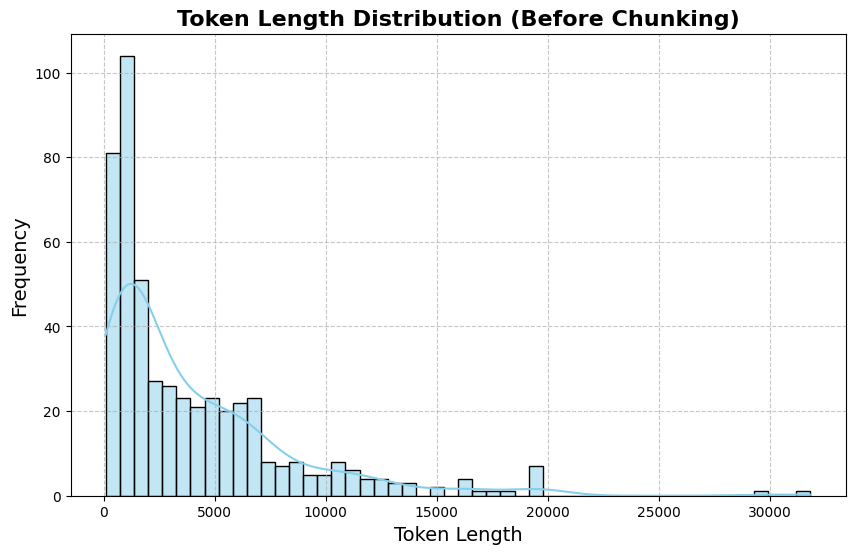

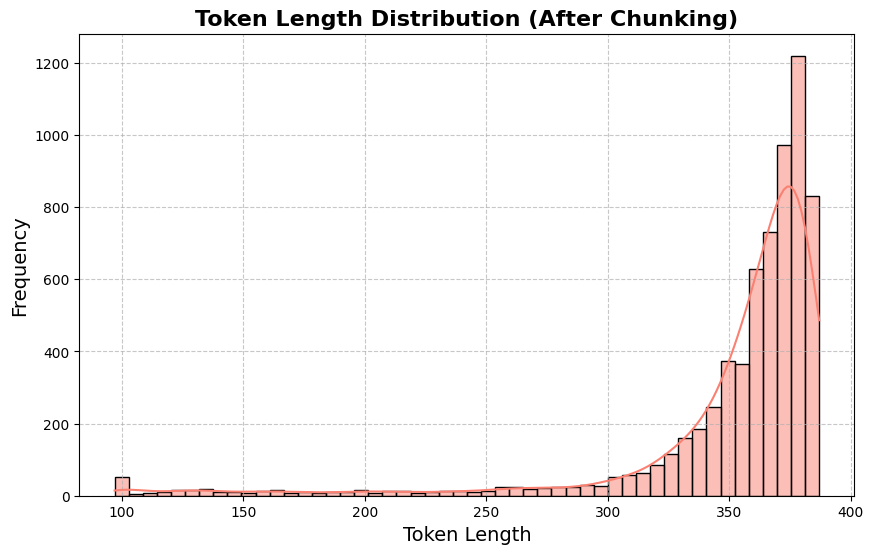

In [52]:
visualize_token_lengths(RAW_KNOWLEDGE_BASE, docs_processed)

## New embedding

## Implementation 

In [1]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

NameError: name 'HuggingFaceEmbeddings' is not defined

In [58]:
def main():
    # Fetch raw knowledge base
    print("Loading raw knowledge base...")
    RAW_KNOWLEDGE_BASE = fetch_data(API_BASE_URL + "opinions/", limit=total_records)

    # Check no. of records fetched
    print(f"Number of records fetched: {len(RAW_KNOWLEDGE_BASE)}")

    # Process the documents
    print("Processing knowledge base...")
    docs_processed = process_knowledge_base(RAW_KNOWLEDGE_BASE)


    # Check number of documents processed (this includes chunking)
    print(f"Number of documents processed: {len(docs_processed)}")


    # Initialise FAISS and add embeddings
    print("Indexing embeddings...")
    vector_store = initialise_faiss(docs_processed, embedding_model)

    # Save FAISS index
    print(f"Saving FAISS index to {FAISS_INDEX_PATH}...")
    vector_store.save_local(FAISS_INDEX_PATH)

    print("FAISS index created and saved successfully.")

In [59]:
import time

if __name__ == "__main__":
    start_time = time.time()  # Record the start time
    main()  
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate elapsed time

    print(f"Execution time: {elapsed_time:.2f} seconds")


Loading raw knowledge base...
Error: 502 - <!DOCTYPE html>
<html lang="en"><head>
<meta http-equiv="content-type" content="text/html; charset=UTF-8">
  <meta charset="utf-8">
  <meta http-equiv="Content-Language" content="en">
  <meta name="language" content="en_us">
  <meta name="viewport" content="width=device-width,initial-scale=1">
  <link href="/errors_5xx/error-assets/font-awesome.css" rel="stylesheet">

  <title>Yikes, something went wrong â CourtListener.com</title>

  <link rel="stylesheet" href="/errors_5xx/error-assets/bootstrap.css" type="text/css">
  <link rel="stylesheet" href="/errors_5xx/error-assets/override.css" type="text/css" media="screen, projection">
</head>

<body class="">
<div class="container round-bottom">
  <header class="row">
    <!-- Static navbar -->
    <div class="navbar navbar-default" role="navigation">
      <div class="container-fluid">
        <div class="navbar-header">
          <a class="navbar-brand" href="https://www.courtlistener.com/">
 

Processing documents: 100%|████████████████| 1900/1900 [00:51<00:00, 37.12it/s]


Number of documents processed: 30703
Indexing embeddings...
Saving FAISS index to faiss_legal_rag_index.index...
FAISS index created and saved successfully.
Execution time: 809.36 seconds


In [60]:
vector_store = FAISS.load_local(FAISS_INDEX_PATH, embedding_model, allow_dangerous_deserialization=True)
print(f"Number of vectors in FAISS index: {vector_store.index.ntotal}")

Number of vectors in FAISS index: 30703


# Query

## Query the FAISS Index using old model

In [79]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # Change to another available GPU index

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings

In [6]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# Load the FAISS index
vector_store = FAISS.load_local(
    folder_path="faiss_legal_rag_index.index",
    embeddings=embedding_model,
    allow_dangerous_deserialization=True  # Enable deserialization
)

print("FAISS index loaded successfully!")

/home/renyang/ruxing/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/renyang/ruxing/.local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


FAISS index loaded successfully!


In [15]:
query = "Find cases similar to Miranda v. Arizona, 384 U.S. 436 (1966)."

top_results = vector_store.similarity_search(query, k=10)  
for i, result in enumerate(top_results):
    print(f"Result {i + 1}:\n{result.page_content}\n")

Result 1:
concern events that occurred as early as october 27, 2021, and include two arrests on november 11, 2021, and december 23, 2021. ( second am. compl. [ # 27 ], ¶ ¶ 1, 15, 25, 33, 38. ) 3 she alleges that her first arrest involved an unlawful traffic stop by defendant hawk, an unlawful search of her car by two defendant john does, and an unlawful detention, all in violation of the fourth amendment. ( second am. compl. [ # 27 ], ¶ ¶ 15, 20 – 21. ) she further alleges that, while in custody, her fifth amendment rights were violated when the police continued to question her despite invoking her right to remain silent ; her sixth amendment right to counsel was violated ; her fourteenth amendment right to due process was violated due to insufficient medical care ; and her rights under the americans with disabilities act ( “ ada ” ) were violated. ( second am. compl. [ # 27 ], ¶ ¶ 25, 28 – 31. ) as to ms. bays ’ s second arrest, which occurred on december 23, 2021, she pleads that def

In [56]:
query = "Find decisions similar to Gideon v. Wainwright, 372 U.S. 335 (1963)."

top_results = vector_store.similarity_search(query, k=10)  
for i, result in enumerate(top_results):
    print(f"Result {i + 1}:\n{result.page_content}\n")

Result 1:
usca4 appeal : 23 - 4378 doc : 55 filed : 02 / 27 / 2025 pg : 1 of 20 published united states court of appeals for the fourth circuit no. 23 - 4377 united states of america, plaintiff – appellee, v. rhonda notgrass, defendant – appellant. no. 23 - 4378 united states of america, plaintiff – appellee, v. robert notgrass, defendant – appellant. appeals from the united states district court for the southern district of west virginia, at charleston. irene c. berger, district judge. ( 2 : 23 - cr - 00016 - 1 ; 2 : 23 - cr - 00017 - 1 ) argued : september 24, 2024 decided : february 27, 2025 before king and richardson, circuit judges, and william l. osteen, jr., united states district judge for the middle district of north carolina, sitting by designation. usca4 appeal : 23 - 4378 doc : 55 filed : 02 / 27 / 2025 pg : 2 of 20 affirmed by published opinion. judge richardson wrote the opinion, in which judge king and judge osteen joined. argued : jonathan d. byrne, office of the federa

In [57]:
query = "Retrieve cases discussing the same issues as Citizens United v. FEC, 558 U.S. 310 (2010)."

top_results = vector_store.similarity_search(query, k=10)  
for i, result in enumerate(top_results):
    print(f"Result {i + 1}:\n{result.page_content}\n")

Result 1:
., green - doyle v. dep ’ t of homeland sec., 817 f. app ’ x 983, 986 ( fed. cir. 2020 ) ( finding plaintiff had presented a “ mixed case ” when she claimed that she had been fired in retaliation for contacting the eeoc and dismissing appeal for lack of jurisdiction ) ; diggs v. dep ’ t of hous. & urban dev., 670 f. 3d 1353, 1358 ( fed. cir. 2011 ) ( stating that “ affirmative defenses of reprisal for prior eeo activity are assertion [ s ] of discrimination under title vii and within the meaning of 5 u. s. c. § 7702, ” which deprive the federal circuit of jurisdiction ) ; see also docket sheet [ # 1 - 3 ] at 171 ( federal circuit order explaining that “ ‘ [ c ] ases of discrimination, ’ where the petitioner appealed an adverse action to the board and raised a claim of covered discrimination, including retaliation,... belong in district court ” ). 2. law of the case the “ law of the case ” doctrine states that, “ when a court decides upon a rule of law, that decision should co

In [60]:
query = "Find opinions similar to New York Times Co. v. Sullivan, 376 U.S. 254 (1964)."

top_results = vector_store.similarity_search(query, k=10)  
for i, result in enumerate(top_results):
    print(f"Result {i + 1}:\n{result.page_content}\n")

Result 1:
##7 ( 11th cir. 2009 ). 26 trump v. cable news network, inc., 2023 wl 8433599, at * 1 ( s. d. fla. 2023 ) ( quoting holland v. florida, 2007 wl 9705926, at * 1 ( s. d. fla. 2007 ) ) ; see also williams v. cruise ships catering & serv. int ’ l, n. v., 320 f. supp. 2d 1347, 1358 ( s. d. fla. 2004 ) ( “ reconsideration of a previous order is ‘ an extraordinary remedy, to be employed sparingly. ’ ” ) ( quoting mannings v. school board of hillsborough county, 149 f. r. d. 235, 235 ( m. d. fla. 1993 ) ). 27 ecf no. 46, at ¶ 7. 28 s. e. c. v. simmons, 241 fed. app ’ x 660, 663 ( 11th cir. 2007 ) ( citing solaroll shade & shutter corp., inc. v. bio - energy systems, inc., 803 f. 2d 1130, 1133 ( 11th cir. 1986 ) ).

Result 2:
. osborn v. kemp, 991 a. 2d 1153, 1160 ( del. 2010 ) ) ( internal quotation marks omitted ). 64 benchmark invs. llc, 2024 wl 3567367 at * 6 ( quoting osborn ex rel. osborn, 991 a. 2d at 1160 ). 65 kuhn const., inc. v. diamond state port corp., 990 a. 2d 393, 396 

In [61]:
query = "Locate cases that follow the precedent set by United States v. Lopez, 514 U.S. 549 (1995)"

top_results = vector_store.similarity_search(query, k=10)  
for i, result in enumerate(top_results):
    print(f"Result {i + 1}:\n{result.page_content}\n")

Result 1:
00051 - cv with cause number 03 - 24 - 00130 - cv for all purposes. the issues, records, and documents filed in cause number 03 - 25 - 00051 - cv are consolidated into cause number 03 - 24 - 00130 - cv. the consolidated appeal shall proceed under appeal number 03 - 24 - 00130 - cv and cause number 03 - 25 - 00051 - cv is hereby dismissed. see tex. r. app. p. 42. 1 ( a ). _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ rosa lopez theofanis, justice before justices theofanis, crump, and ellis no. 03 - 24 - 00130 - cv consolidated no. 03 - 25 - 00051 - cv dismissed filed : february 26, 2025 2

Result 2:
not for publication filed united states court of appeals feb 28 2025 molly c. dwyer, clerk u. s. court of appeals for the ninth circuit ricardo aguilar garcia, aka nos. 19 - 71917 ricardo aguilargarcia, 23 - 1536 agency no. petitioner, a204 - 909 - 937 v. memorandum * pamela bondi, attorney general, respondent. on petition for review of an orde

In [64]:
query = "Find cases addressing similar issues as Planned Parenthood v. Casey, 505 U.S. 833 (1992)."

top_results = vector_store.similarity_search(query, k=10)  
for i, result in enumerate(top_results):
    print(f"Result {i + 1}:\n{result.page_content}\n")

Result 1:
defendant asserts plaintiff ’ s complaint fails to state a claim because receiving treatment 4 for infertility and “ hoping to become pregnant ” does not make her a member of a protected 5 class — specifically, pregnancy - related sex discrimination. ( doc. 7 at 8 ). defendant argues 6 plaintiff does not belong to a protected class because she was not pregnant, had not given 7 birth, and did not have a medical condition related to pregnancy or childbirth when she was 8 not selected. ( id. ) plaintiff counters she is a member of a protected class because of her 9 potential to become pregnant and her ongoing, outspoken, efforts to become pregnant. 10 ( doc. 8 at 9 ). 11 in support of its assertion, defendant relies on two out of circuit cases, laporta v. 12 wal - mart stores, inc., 163 f. supp. 2d 758 ( w. d. mich. 2001 ) and krauel v. iowa 13 methodist med. ctr., 95 f. 3d 674 ( 8th cir. 1996 ). ( doc. 7 at 8 ), neither of which are 14 persuasive. krauel held that a health insu

In [65]:
query = "Find judicial opinions aligned with Texas v. Johnson, 491 U.S. 397 (1989)."

top_results = vector_store.similarity_search(query, k=10)  
for i, result in enumerate(top_results):
    print(f"Result {i + 1}:\n{result.page_content}\n")

Result 1:
texas court of appeals, third district, at austin no. 03 - 24 - 00496 - cv colin lee johnson, appellant v. amanda kay like, appellee from the 250th district court of travis county no. d - 1 - ag - 19 - 001394, the honorable don r. burgess, judge presiding memorandum opinion appellant colin lee johnson has filed an unopposed motion to dismiss this appeal. we grant appellant ’ s motion and dismiss the appeal. see tex. r. app. p. 42. 1 ( a ). _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ maggie ellis, justice before chief justice byrne, justices kelly and ellis dismissed on appellant ’ s motion filed : february 27, 2025

Result 2:
court of appeals, 486 u. s. 429, 438 n. 10, 108 s. ct. 1895, 1902 n. 10, 100 l. ed. 2d 440. after a review of the entire record in this appeal, we have determined levine v. the state of texas page 2 the appeal to be wholly frivolous. see bledsoe v. state, 178 s. w. 3d 824, 826 – 28 ( tex. crim. app. 2005 ). accordi

# Integrate into RAG Pipeline

In [65]:
# !pip install transformers torch

In [1]:
from langchain_huggingface import HuggingFaceEmbeddings

In [8]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# Load the FAISS index
vector_store = FAISS.load_local(
    folder_path="faiss_legal_rag_index.index",
    embeddings=embedding_model,
    allow_dangerous_deserialization=True  # Enable deserialization
)

print("FAISS index loaded successfully!")

/home/renyang/ruxing/.local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


FAISS index loaded successfully!


In [11]:
def generate_text(prompt, tokenizer, model):
    """Generates text using LLaMA and removes the original prompt from the output."""
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=512, temperature=0.7, top_p=0.9)
    
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Remove the prompt part by extracting only the response text
    response = full_response.split("**Example Output:**")[-1].strip()
    
    return response

In [12]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from transformers import LlamaForCausalLM, LlamaTokenizer, pipeline
from sentence_transformers import CrossEncoder
import torch

def load_llama_model(model_name="meta-llama/Llama-2-7b-chat-hf"):
    """Load LLaMA 2 model and tokenizer."""
    tokenizer = LlamaTokenizer.from_pretrained(model_name)
    model = LlamaForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    return tokenizer, model


def rerank_documents(query, retrieved_docs, reranker_model):
    """Reranks documents using a cross-encoder model."""
    query_doc_pairs = [(query, doc.page_content) for doc in retrieved_docs]
    scores = reranker_model.predict(query_doc_pairs)

    # Sort documents by score (descending)
    ranked_results = sorted(zip(retrieved_docs, scores), key=lambda x: x[1], reverse=True)
    
    # Return top 3 reranked results
    return [doc for doc, score in ranked_results[:3]]

def rag_pipeline(query, vector_store, tokenizer, model, reranker_model):
    """End-to-end RAG pipeline: Retrieve, Rerank, and Generate with LLaMA."""
    
    # Retrieve Top-10 Documents from FAISS
    retrieved_docs = vector_store.similarity_search(query, k=10)

    # Apply Cross-Encoder Reranking
    top_results = rerank_documents(query, retrieved_docs, reranker_model)

    # Extract text from top reranked documents
    retrieved_texts = "\n\n".join([result.page_content for result in top_results])

    # Format Prompt for LLaMA
    prompt = f"""
    You are an AI legal assistant specializing in case law research. 
    Your task is to analyze relevant legal precedents and find cases similar to the given query.
    
    **User Query:** "{query}"
    
    **Relevant Legal Opinions Retrieved:**
    {retrieved_texts}
    
    **Instructions:**
    - Identify and summarize key legal principles from the retrieved cases.
    - Compare the retrieved cases to the query, highlighting similarities in legal reasoning, facts, and rulings.
    - If applicable, note any cases that set contrasting precedents.
    - Use formal legal language and avoid speculative responses.
    - If no highly relevant cases are found, explicitly state that and suggest alternative approaches.
    
    **Output Format:**
    1. Similar Cases Identified:
       - Case Name: [Case Title]
       - Summary: [Brief summary of case facts and ruling]
       - Similarity to Query: [Explain why it's relevant]
       
    2. Key Legal Principles:
       - Principle 1: [Description]
       - Principle 2: [Description]
       
    3. Contrasting Precedents (if any):
       - Case Name: [Case Title]
       - Key Difference: [Explain how it differs]
    
    4. Conclusion: [Final summary]
    """

    # Generate Response using LLaMA
    generated_text = generate_text(prompt, tokenizer, model)
    
    return generated_text




In [51]:
import torch
torch.cuda.empty_cache()

In [9]:
# Load LLaMA model & tokenizer
tokenizer, model = load_llama_model()

/home/renyang/ruxing/.local/lib/python3.10/site-packages/accelerate/utils/modeling.py:1462: UserWarning: Current model requires 4224 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# Load reranker model
reranker_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
# reranker_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", device="cpu")

In [14]:
query = "Find cases similar to Miranda v. Arizona, 384 U.S. 436 (1966)."
rag_response = rag_pipeline(query, vector_store, tokenizer, model, reranker_model)
print("\nGenerated Response:")
print(rag_response)

In [104]:
query = "Find cases similar to Miranda v. Arizona, 384 U.S. 436 (1966)."
llama_generated = generate_text(query, tokenizer, model)
print(llama_generated)

Find cases similar to Miranda v. Arizona, 384 U.S. 436 (1966).
The Supreme Court case Miranda v. Arizona, 384 U.S. 436 (1966), established the requirement that police must inform suspects of their rights before questioning them. Here are some similar cases:
1. Dickerson v. United States, 508 U.S. 367 (1993): In this case, the Supreme Court held that the Miranda warning is required for all custodial interrogations, regardless of the presence of physical coercion or the duration of the interrogation.
2. Maryland v. Shatzer, 559 U.S. 98 (2010): The Court ruled that the Miranda warning is not required for all interrogations, but only for those that occur during a custodial interrogation.
3. Berghuis v. Thompkins, 560 U.S. 370 (2010): The Court held that a suspect's request for an attorney during interrogation does not automatically terminate the interrogation, but rather, the police may continue to question the suspect until they request an attorney.
4. Michigan v. Lyons, 471 U.S. 1 (1985)

In [ ]:
query = "Find decisions similar to Gideon v. Wainwright, 372 U.S. 335 (1963)."
llama_generated = generate_text(query, tokenizer, model)
print(llama_generated)

In [ ]:
print("BERTScore:", evaluate_bert_score(query, llama_generated))

In [ ]:
print("Cosine Similarity:", evaluate_cosine_similarity(query, llama_generated))

In [ ]:
query = "Find decisions similar to Gideon v. Wainwright, 372 U.S. 335 (1963)."
rag_response = rag_pipeline(query, vector_store, tokenizer, model, reranker_model)
print("\nGenerated Response:")
print(rag_response)

In [ ]:
print("BERTScore:", evaluate_bert_score(query, rag_response))

In [ ]:
print("Cosine Similarity:", evaluate_cosine_similarity(query, rag_response))

In [ ]:
query = "Retrieve cases discussing the same issues as Citizens United v. FEC, 558 U.S. 310 (2010)."
llama_generated = generate_text(query, tokenizer, model)
print(llama_generated)

In [ ]:
print("BERTScore:", evaluate_bert_score(query, llama_generated))

In [ ]:
print("Cosine Similarity:", evaluate_cosine_similarity(query, llama_generated))

In [ ]:
query = "Retrieve cases discussing the same issues as Citizens United v. FEC, 558 U.S. 310 (2010)."
rag_response = rag_pipeline(query, vector_store, tokenizer, model, reranker_model)
print("\nGenerated Response:")
print(rag_response)

In [ ]:
print("BERTScore:", evaluate_bert_score(query, rag_response))

In [ ]:
print("Cosine Similarity:", evaluate_cosine_similarity(query, rag_response))

In [ ]:
query = "Find opinions similar to New York Times Co. v. Sullivan, 376 U.S. 254 (1964)."
llama_generated = generate_text(query, tokenizer, model)
print(llama_generated)

In [ ]:
print("BERTScore:", evaluate_bert_score(query, llama_generated))

In [ ]:
print("Cosine Similarity:", evaluate_cosine_similarity(query, llama_generated))

In [ ]:
query = "Find opinions similar to New York Times Co. v. Sullivan, 376 U.S. 254 (1964)."
rag_response = rag_pipeline(query, vector_store, tokenizer, model, reranker_model)
print("\nGenerated Response:")
print(rag_response)

In [ ]:
print("BERTScore:", evaluate_bert_score(query, rag_response))

In [ ]:
print("Cosine Similarity:", evaluate_cosine_similarity(query, rag_response))

In [ ]:
query = "Locate cases that follow the precedent set by United States v. Lopez, 514 U.S. 549 (1995)"
llama_generated = generate_text(query, tokenizer, model)
print(llama_generated)

In [ ]:
print("BERTScore:", evaluate_bert_score(query, llama_generated))

In [ ]:
print("Cosine Similarity:", evaluate_cosine_similarity(query, llama_generated))

In [ ]:
query = "Locate cases that follow the precedent set by United States v. Lopez, 514 U.S. 549 (1995)"
rag_response = rag_pipeline(query, vector_store, tokenizer, model, reranker_model)
print("\nGenerated Response:")
print(rag_response)

In [ ]:
print("BERTScore:", evaluate_bert_score(query, rag_response))

In [ ]:
print("Cosine Similarity:", evaluate_cosine_similarity(query, rag_response))

# Evaluation

In [55]:
# !pip install bert-score

In [16]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from bert_score import score as bert_score

def evaluate_bert_score(query, generated):
    P, R, F1 = bert_score([generated], [query], lang="en")
    return F1.mean().item()

# def evaluate_cosine_similarity(query, generated):
#     model = SentenceTransformer('all-MiniLM-L6-v2')
#     # model = SentenceTransformer("all-mpnet-base-v2")
#     embeddings = model.encode([query, generated], convert_to_tensor=True)
#     return util.pytorch_cos_sim(embeddings[0], embeddings[1]).item()


In [17]:
from langchain.embeddings import HuggingFaceEmbeddings
import torch
from sentence_transformers.util import pytorch_cos_sim

def evaluate_cosine_similarity(query, generated):
    embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    
    # Generate embeddings
    query_embedding = torch.tensor(embedding_model.embed_query(query))
    generated_embedding = torch.tensor(embedding_model.embed_query(generated))
    
    # Compute cosine similarity
    return pytorch_cos_sim(query_embedding, generated_embedding).item()


In [40]:
def evaluate_bert_score(query, generated):
    P, R, F1 = bert_score([generated], [query], lang="en", device="cpu")
    return F1.mean().item()

In [35]:
print("BERTScore:", evaluate_bert_score(query, generated))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore: 0.8537312150001526


In [ ]:
print("Cosine Similarity:", evaluate_cosine_similarity(query, generated))
# print("Hallucinated Cases:", detect_hallucinations(generated, legal_cases_db))

In [101]:
# For RAG
print("BERTScore:", evaluate_bert_score(query, generated))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore: 0.8537313342094421


In [90]:
import torch
torch.cuda.empty_cache()

In [93]:
import torch
print(torch.cuda.memory_allocated())  # Current memory usage
print(torch.cuda.memory_reserved())   # Total memory reserved

539099648
717225984


# Evaluation

In [27]:
# !pip install git+https://github.com/ZeroEntropy-AI/legalbenchrag.git
# !pip install datasets transformers sentence-transformers evaluate

In [92]:
import gc
import torch

gc.collect()  # Clears Python garbage collector (CPU memory)
torch.cuda.empty_cache()  # Clears PyTorch GPU memory cache

# Evaluation (Deprecated)

In [20]:
import requests

def get_relevant_cases(citation):
    base_url = "https://www.courtlistener.com/api/rest/v4/opinions/"
    response = requests.get(f"{base_url}?citation={citation}")
    
    if response.status_code == 200:
        data = response.json()
        if data["results"]:
            case = data["results"][0]
            relevant_cases = case.get("cites", []) + case.get("cited_by", []) 
            return relevant_cases
        else:
            return []
    else:
        print("Error fetching data")
        return []

# Example: Find cases related to Miranda v. Arizona (384 U.S. 436)
citation = "384 U.S. 436"
relevant_cases = get_relevant_cases(citation)
print("Relevant Cases:", relevant_cases)

Relevant Cases: []


In [21]:
citation = "496 U.S. 498"
relevant_cases = get_relevant_cases(citation)
print("Relevant Cases:", relevant_cases)

Relevant Cases: []
